# Loading Dataset

As the dataset is small, so we can load it entirely from hard drive to memory for faster processing. We do not need any dataset loader for this problem.

In [1]:
# import important packages

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# set path to the dataset
IMAGES_PATH = "dataset/faces"

In [2]:
images_dict = dict()
for user_id in os.listdir(IMAGES_PATH):
    user_id_path = os.path.join(IMAGES_PATH, user_id)
    for image_name in os.listdir(user_id_path):
        _, extension = os.path.splitext(image_name)
        if extension != ".txt":
            images_dict[image_name] = os.path.join(os.path.join(user_id_path, image_name))

print(f"Total images found: {len(images_dict)}")

Total images found: 19370


In [3]:
df_1 = pd.read_csv("dataset/fold_0_data.txt", delimiter="\t")
df_2 = pd.read_csv("dataset/fold_1_data.txt", delimiter="\t")
df_3 = pd.read_csv("dataset/fold_2_data.txt", delimiter="\t")
df_4 = pd.read_csv("dataset/fold_3_data.txt", delimiter="\t")
df_5 = pd.read_csv("dataset/fold_4_data.txt", delimiter="\t")

df = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0)
df["image_name"] = "coarse_tilt_aligned_face." + df["face_id"].astype(str) + "." + df["original_image"].astype(str)

print(f"Total images found: {len(df)}")
df.head()

Total images found: 19370


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,image_name
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,coarse_tilt_aligned_face.1.10399646885_67c7d20...
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,coarse_tilt_aligned_face.2.10424815813_e94629b...
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,coarse_tilt_aligned_face.1.10437979845_5985be4...
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,coarse_tilt_aligned_face.3.10437979845_5985be4...
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,coarse_tilt_aligned_face.2.11816644924_075c3d8...


In [4]:
def cropPhoto(image, pnt, box, size=0.1):
    [x1, y1, x2, y2] = box
    box_w, box_h = (x2 - x1), (y2 - y1)
    img_h, img_w = image.shape[:2]
    
    x1c = int(max(0, x1 - (box_w * size)))
    y1c = int(max(0, y1 - (box_h * size)))
    x2c = int(min(img_w, x2 + (box_w * size)))
    y2c = int(min(img_h, y2 + (box_h * size)))
    crop = image[y1c:y2c, x1c:x2c]
    return crop

In [7]:
import os
from tqdm import tqdm
from mtcnn_pytorch import MTCNN
from PIL import Image

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN()

# load dataset
DATASET_PATH = "dataset"
INPUT_SHAPE = (128, 128)

# initialize the X and y lists to store images and class labels
X, y = [], []

label_mapping_dict = {
    0: "female",
    1: "male"
}

def maxArea(box):
    return ((box[2] - box[0]) * (box[3] - box[1]))

# class hist is a list containing the frequency of class instances. Used to draw the histogram
class_hist = []
for row_index, row in tqdm(df.iterrows(), total=len(df)):
    
    gender = 0 if row["gender"] == "f" else 1
    class_hist.append(gender)
    
    # read the image using openCV
    img_path = os.path.join(IMAGES_PATH, row["user_id"], row["image_name"])
    img = Image.open(img_path)
    img_w, img_h = img.size
    
    # Get cropped and prewhitened image tensor
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    
    # skip if no face is detected
    if boxes is None:
        continue
        
    # if there are multiple faces, pick the one with maximum box area
    box = max(boxes, key=maxArea)
    
    landmarks_ = points[np.where(boxes == box)]
    nose_landmark = (int(landmarks_[2][0]), int(landmarks_[2][1]))
    
    xmin, ymin, xmax, ymax = [int(v) for v in box]
    
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(img_w, xmax)
    ymax = min(img_h, ymax)
    
    img = np.array(img, dtype=np.uint8)
            
    # crop the face
    img = cropPhoto(img, nose_landmark, [xmin, ymin, xmax, ymax], size=0.3)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess 1.
    # resize img to a fixed size
    img = cv2.resize(img, INPUT_SHAPE, interpolation=cv2.INTER_AREA)
    
    # append the loaded image and class index to X and y lists
    X.append(img)
    y.append(gender)
    
#     if row_index == 20:
#         break


# converting lists to numpy array
X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.int64)

print("X shape", X.shape)
print("y shape", y.shape)

100%|████████████████████████████████████████████████████████████████████████████| 19370/19370 [25:00<00:00, 12.91it/s]


X shape (19338, 128, 128, 3)
y shape (19338,)


### Plot the Loaded Dataset

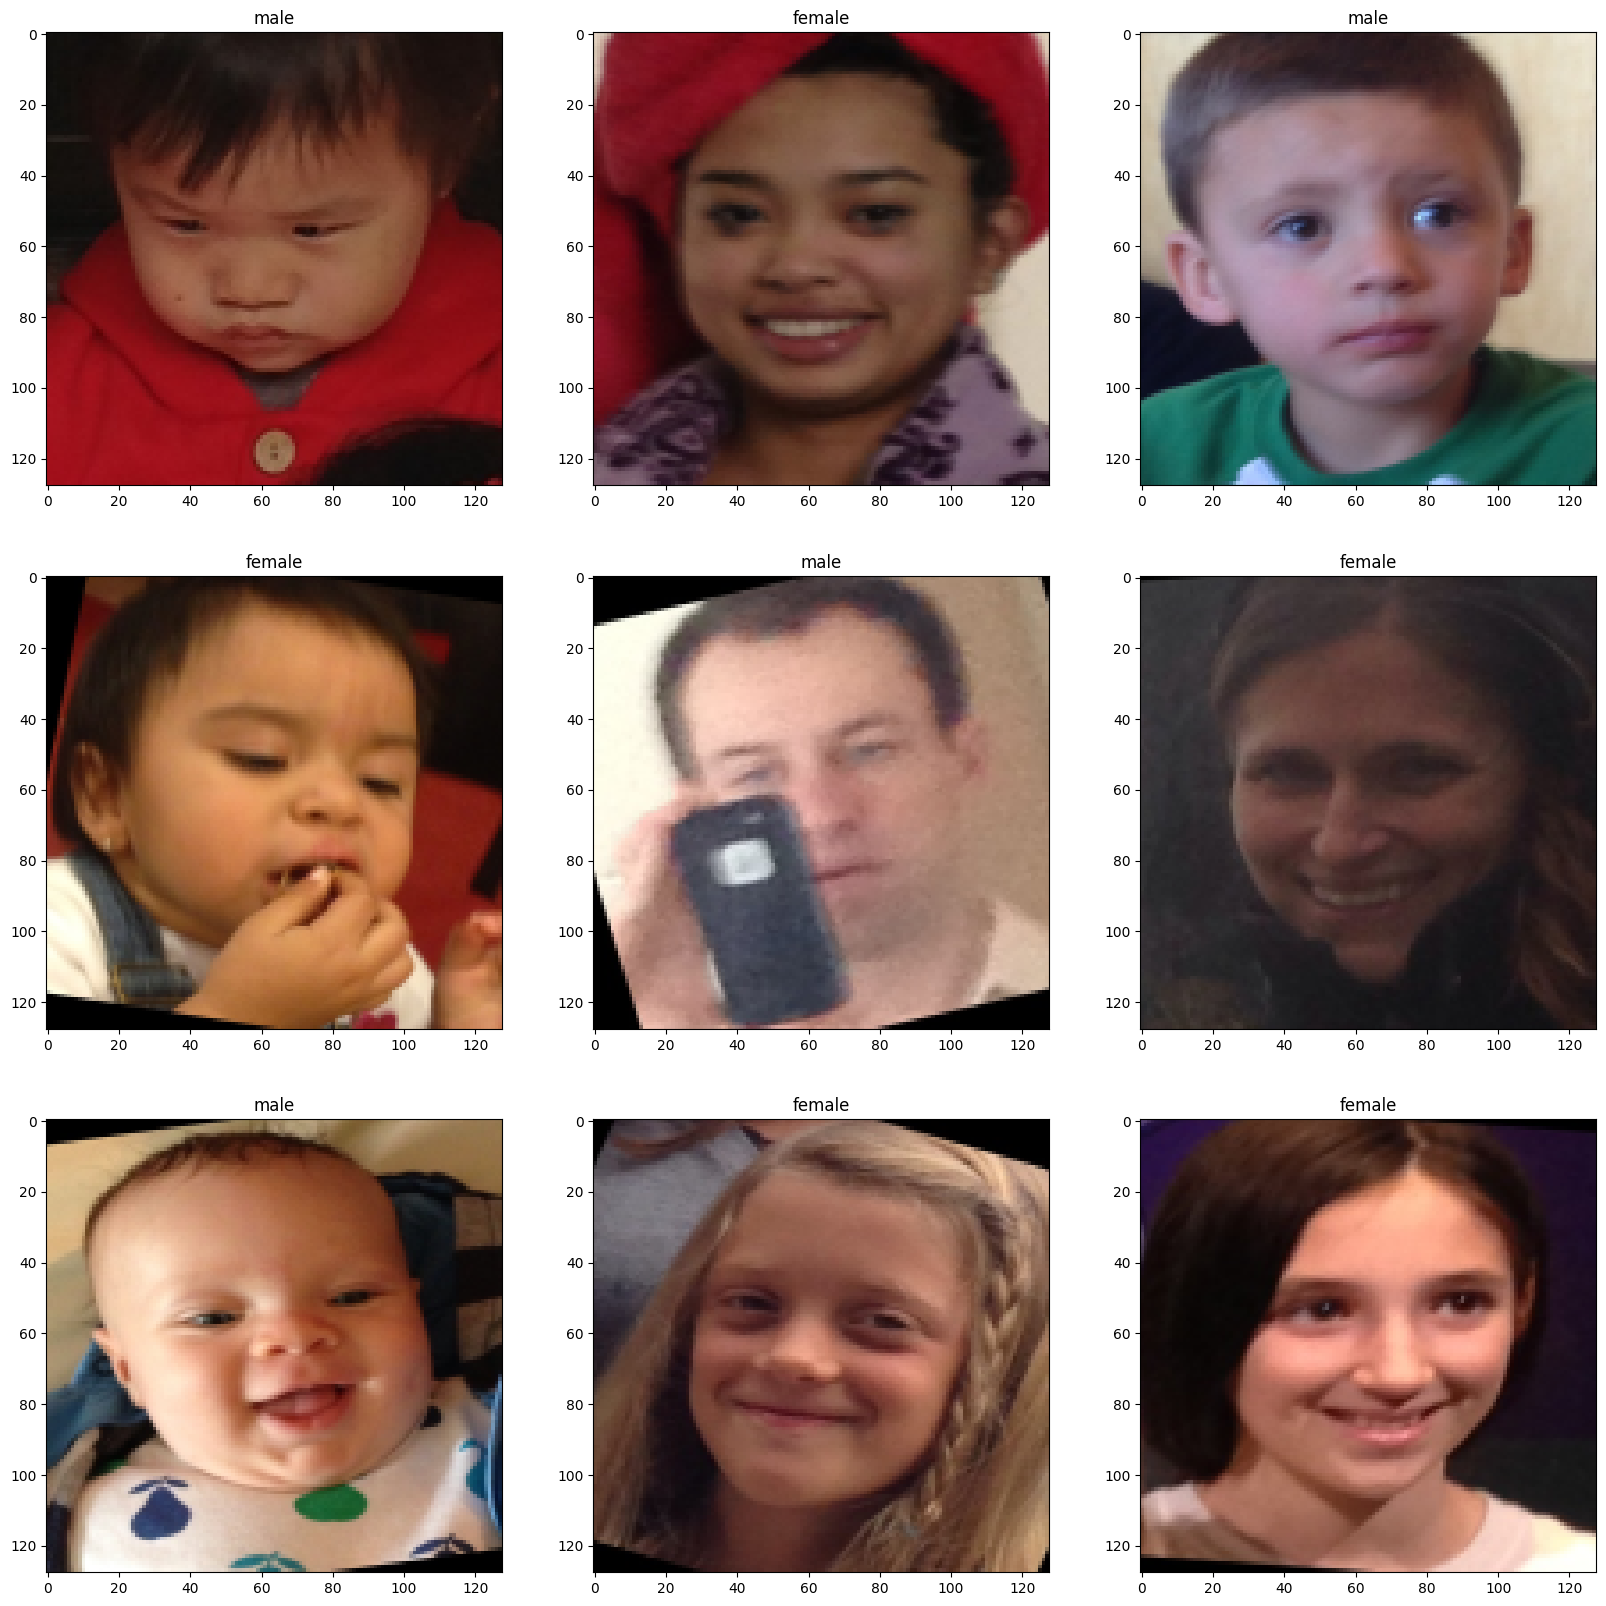

In [8]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
import os

def plotSamples(X, shuffle=False):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    index = 0
    for row in range(3):
        for col in range(3):
            
            if random:
                index = random.randint(0, len(X))
            else:
                index += 1
                
            image, class_index = X[index], y[index]
            # get the class name
            actual_class = label_mapping_dict[class_index]
            
            if len(image.shape) == 2:
                axes[row][col].imshow(image, cmap="gray", interpolation='nearest', aspect='auto')
            else:
                axes[row][col].imshow(image, interpolation='nearest', aspect='auto')

            axes[row][col].set_title(actual_class)

    plt.show()
    
plotSamples(X, shuffle=True)

### Plot Class Histrogram

Here we can see that the classes Potato___Early_blight and Potato___Late_blight has both 1000 instances, while the class Potato___healthy has only 152 instances.

We can tackle such class imbalance using different techniques. We will be using data augmentation to bring class balance to the dataset.

Class 			 Count
0 	 9372
1 	 9998


<function matplotlib.pyplot.show(close=None, block=None)>

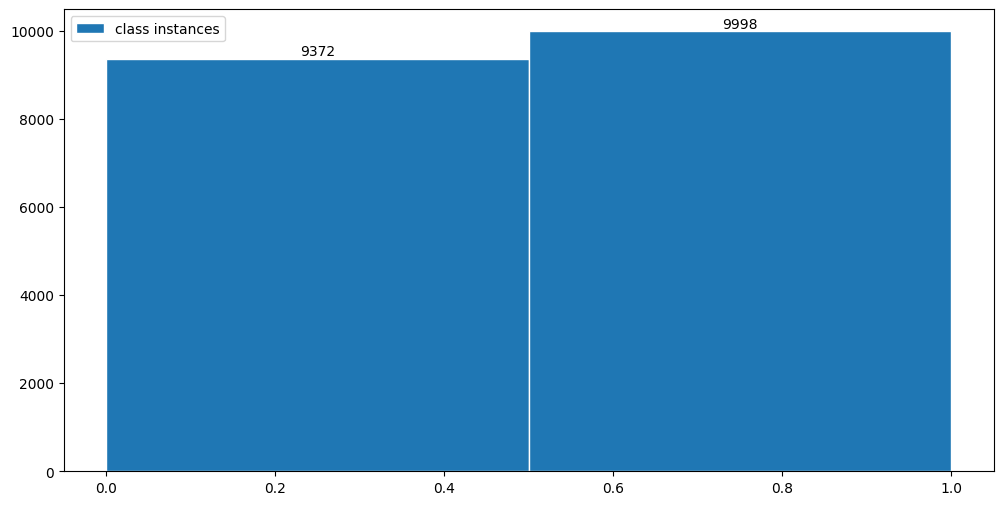

In [12]:
import collections
counter = collections.Counter(class_hist)

print(f"Class \t\t\t Count")
for class_index, count in counter.items():
    print(f"{class_index} \t {count}")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
freq, bins, patches = plt.hist(class_hist, edgecolor='white', label='class instances', bins=len(label_mapping_dict))

# x coordinate for labels
bin_centers = np.diff(bins) * 0.5 + bins[:-1]

n = 0
for fr, x, patch in zip(freq, bin_centers, patches):
  height = int(freq[n])
  plt.annotate("{}".format(height),
               xy = (x, height),             # top left corner of the histogram bar
               xytext = (0,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )
  n += 1

plt.legend()
plt.show

# Dataset Preprocessing

Image data processing is one of the most under-explored problems in the data science community. Every developer has a unique way of doing it. When building a machine learning/computer vision project, a few problems associated with image data include complexity, inaccuracy, and inadequacy. This is why before building a computer vision model, it is essential that the data is preprocessed (cleaned and processed to the desired format) to achieve the desired results.

Now that we’re done with loading the dataset, let’s proceed to data preprocessing.
In this tutorial, we shall look at the following image preprocessing techniques:

1. Data Augmentation - To tackle class imbalance.
2. Guassian Smoothing - As our dataset images are too sharp and noisy.
3. Normalisation - Projecting image data pixels (intensity) to a predefined range of (0, 1)
4. Dimentionality Reduction - Performing PCA to reduce the complexity of the dataset

## Preprocessing 3: Image Normalization

Also referred to as data re-scaling, it is the process of projecting image data pixels (intensity) to a predefined range e.g [0, 1]. This is commonly used on different data formats, and you want to normalize all of them to apply the same algorithms over them.

Normalization is usually applied to convert an image’s pixel values to a typical or more familiar sense. Its benefits include:

- Fairness across all images - For example, scaling all images to an equal range allows all images to contribute equally to the total loss rather than when other images have high and low pixels ranges give strong and weak loss, respectively.

- Provides a standard learning rate - Since high pixel images require a low learning rate and low pixel images high learning rate, re-scaling helps provide a standard learning rate for all images.

Here, we are normalizing our RGB images which are of data type uint8 and are in the range of [0, 255]. The new range will be [0, 1].

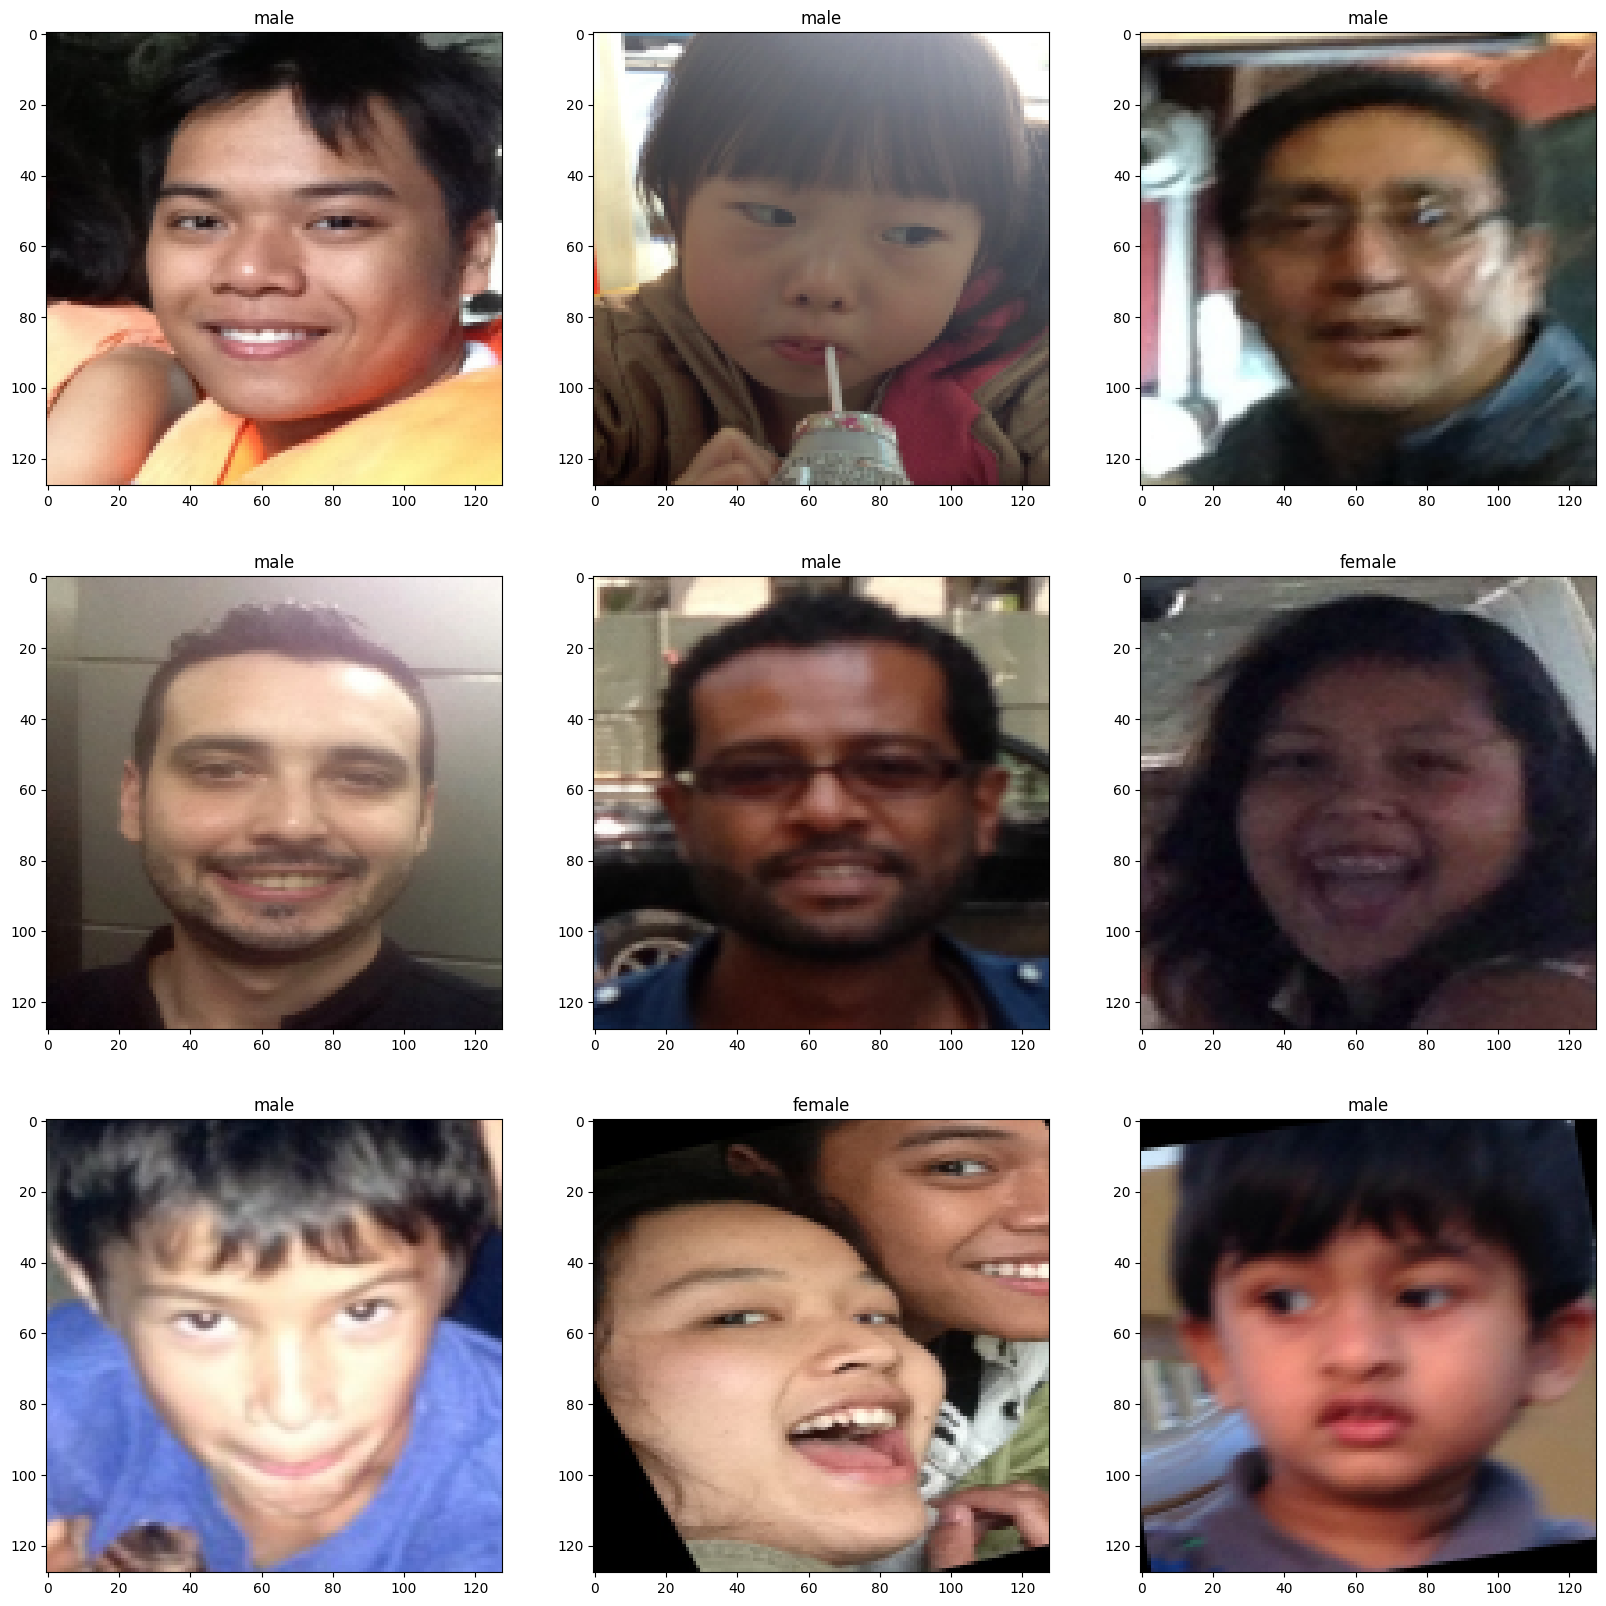

In [10]:
X_normalized = [None for _ in range(len(X))]

for index in range(len(X)):
    img = X[index]
    
    # apply normalization formula here
    # new_range = (x - old_range_minimum) / (old_range_maximum - old_range_minimum)
    norm_image = (img - np.min(img)) / (np.max(img) - np.min(img))
    X_normalized[index] = norm_image

X_normalized = np.array(X_normalized, dtype=np.float32)

# plot samples
plotSamples(X_normalized)

## Preprocessing 4: Principle Components Analysis - Dimentionality Reduction

Scikit-learn Classifiers accepts the training features to be in 2D arrays, which means we can't feed RGB images directly into any scikit-learn classifier. To tackle this situation, we need to reshape or flatten the 3d RGB images into 1D array. But by simply flattening the an RGB image of shape 256x256x3, it will become an 1D array of shape 1x196608 which has a lot of features in it. 

Due to this complexity, the traning time is increased exceedingly and the model will perform poorly. To tackle this problem, we need to perform dimentionality reduction technique by applying PCA (Pricipal Component Analysis). Principal component analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

Here, we are taking the first 500 components which covers upto 90% information when summed up the individual component's varience. This means we have successfully reduced 196608 features to just 500 features by loosing only 10% of the information from the dataset.

In [11]:
# PCA can be easily done by using scikit-learn PCA package
from sklearn.decomposition import PCA
import numpy as np
import pickle 

# First reshape the batch of RGB images which is a 4D array into a 2D array.
print("Shape of the original dataset:", X_normalized.shape)
X_reshaped = X_normalized.reshape((len(X_normalized), -1))
print("Shape of the dataset when flattened:", X_reshaped.shape)

pca = PCA(n_components=50)
pca.fit(X_reshaped)

print("Sum of explained variance ratio for each Principle Component:", sum(pca.explained_variance_ratio_))

# as we have PCA object, now transform the original dataset into a new dataset with 100 features
X_PCA = pca.transform(X_reshaped)

print("Shape of the dataset after applying PCA:", X_PCA.shape)

# Save PCA object which has been trained on the training set
pca_name = 'data/Dataset__Gender__PCA.pkl'
pickle.dump(pca, open(pca_name, "wb"))

Shape of the original dataset: (19338, 128, 128, 3)
Shape of the dataset when flattened: (19338, 49152)
Sum of explained variance ratio for each Principle Component: 0.800620214547962
Shape of the dataset after applying PCA: (19338, 50)


# Splitting the Dataset into Train and Test Sets

In [13]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2

# split into test train
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=TEST_SIZE, random_state=42, shuffle=True)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (15470, 50)
y_train shape (15470,)
X_test shape (3868, 50)
y_test shape (3868,)


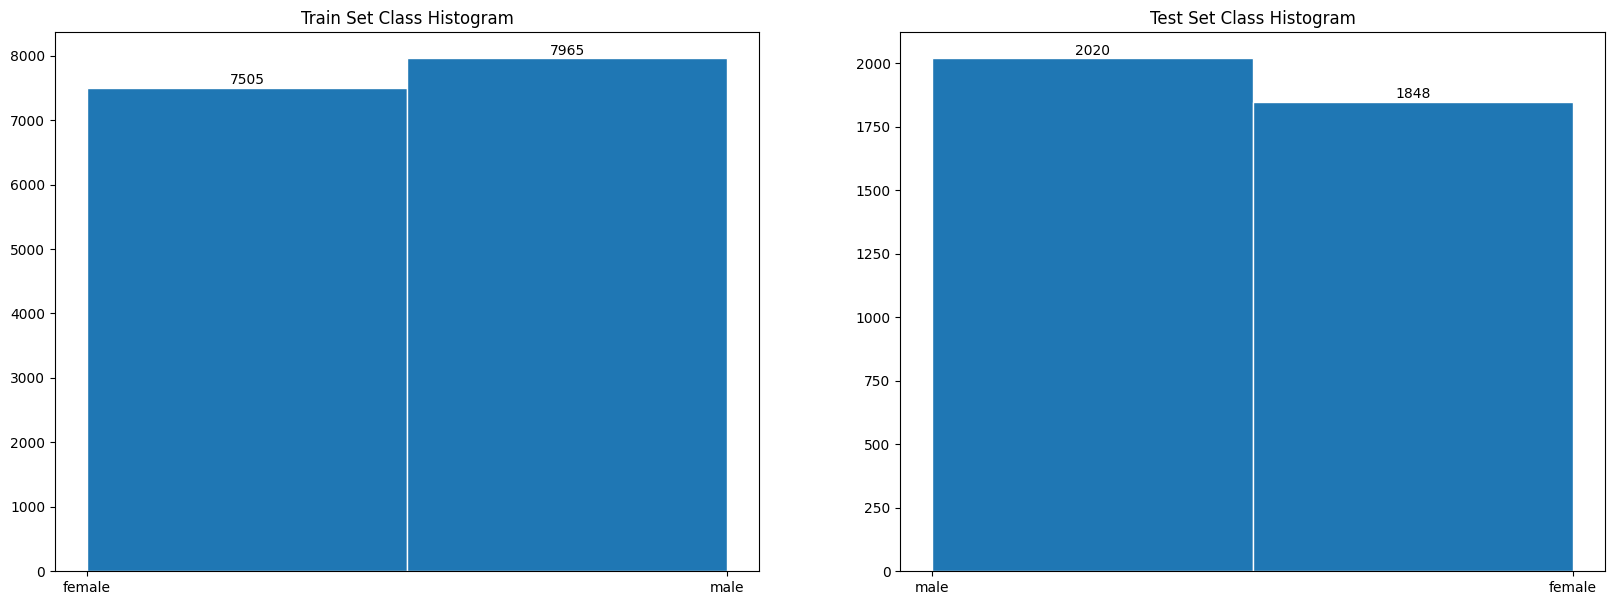

In [17]:
# plot test set class distribution
hist_test = []
for label in y_test:
    hist_test.append(label_mapping_dict[label])

hist_train = []
for label in y_train:
    hist_train.append(label_mapping_dict[label])
    
def plotHist(freq, bins, patches, axis=0):
    # x coordinate for labels
    bin_centers = np.diff(bins) * 0.5 + bins[:-1]
    n = 0
    for fr, x, patch in zip(freq, bin_centers, patches):
      height = int(freq[n])
      axes[axis].annotate("{}".format(height),
                   xy = (x, height),             # top left corner of the histogram bar
                   xytext = (0,0.2),             # offsetting label position above its bar
                   textcoords = "offset points", # Offset (in points) from the *xy* value
                   ha = 'center', va = 'bottom')
      n += 1

# initialize the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# plot training set class histogram
freq, bins, patches = axes[0].hist(hist_train, edgecolor='white', bins=len(label_mapping_dict))
axes[0].set_title("Train Set Class Histogram")
plotHist(freq, bins, patches, axis=0)

# plot testing set class histogram
freq, bins, patches = axes[1].hist(hist_test, edgecolor='white', bins=len(label_mapping_dict))
axes[1].set_title("Test Set Class Histogram")
plotHist(freq, bins, patches, axis=1)
plt.show()

# Training Scikit-Learn Classifiers with Hyperparameter Tuning

As the dataset has been prepared, now it's the time for training different classifiers and then choose the best one. We will be training classifiers with hyperparameter tuning. The performance of a model significantly depends on the value of hyperparameters. Note that there is no way to know in advance the best values for hyperparameters so ideally, we need to try all possible values to know the optimal values.

Fortunately, Scikit-learn provides a builtin package names GridSearchCV for performing hyperparameter tuning. GridSearchCV is the process of performing hyperparameter tuning in order to determine the optimal values for a given model. Doing this manually could take a considerable amount of time and resources and thus we use GridSearchCV to automate the tuning of hyperparameters.

### Support Vector Classifier with GridSearchCV

In [20]:
from sklearn.svm import SVC

svc_clf = SVC()

# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# svc_grid = GridSearchCV(svc_clf, param_grid, refit=True, n_jobs=-1, verbose=2)

# svc_grid.fit(X_train, y_train)

# # print the accuracy on test set for the best estimator
# print("Accuracy Score on the Test Set for the best Estimator")
# svc_grid.best_estimator_.score(X_test, y_test)

svc_clf.fit(X_train, y_train)

# print the accuracy on test set for the best estimator
print("Accuracy Score on the Test Set for the best Estimator")
print(svc_clf.score(X_test, y_test))

best_classifier = svc_clf

Accuracy Score on the Test Set for the best Estimator
0.7779214064115823


### Choosing the best estimator

As we can see that the accuracy on the test set is achieved the highest by the SVC classifier. Hence from the GridSeachCV, we will be choosing the best estimator as the best classifier here.

In [56]:
best_classifier = svc_grid.best_estimator_

# Evaluating Model Performance on the Test Data

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

predictions = best_classifier.predict(X_test)

accuracy_score_ = accuracy_score(predictions, y_test)
precision_score_ = precision_score(predictions, y_test, average="weighted")
recall_score_ = recall_score(predictions, y_test, average="weighted")
f1_score_ = f1_score(predictions, y_test, average="weighted")

print("The following matrices are for the best classifier on the test set.")
print("accuracy:", accuracy_score_)
print("precision:", precision_score_)
print("recall:", recall_score_)
print("f1:", f1_score_)

The following matrices are for the best classifier on the test set.
accuracy: 0.7779214064115823
precision: 0.7779266566042039
recall: 0.7779214064115823
f1: 0.7779239794691823


### Confusion Matrix

<AxesSubplot:>

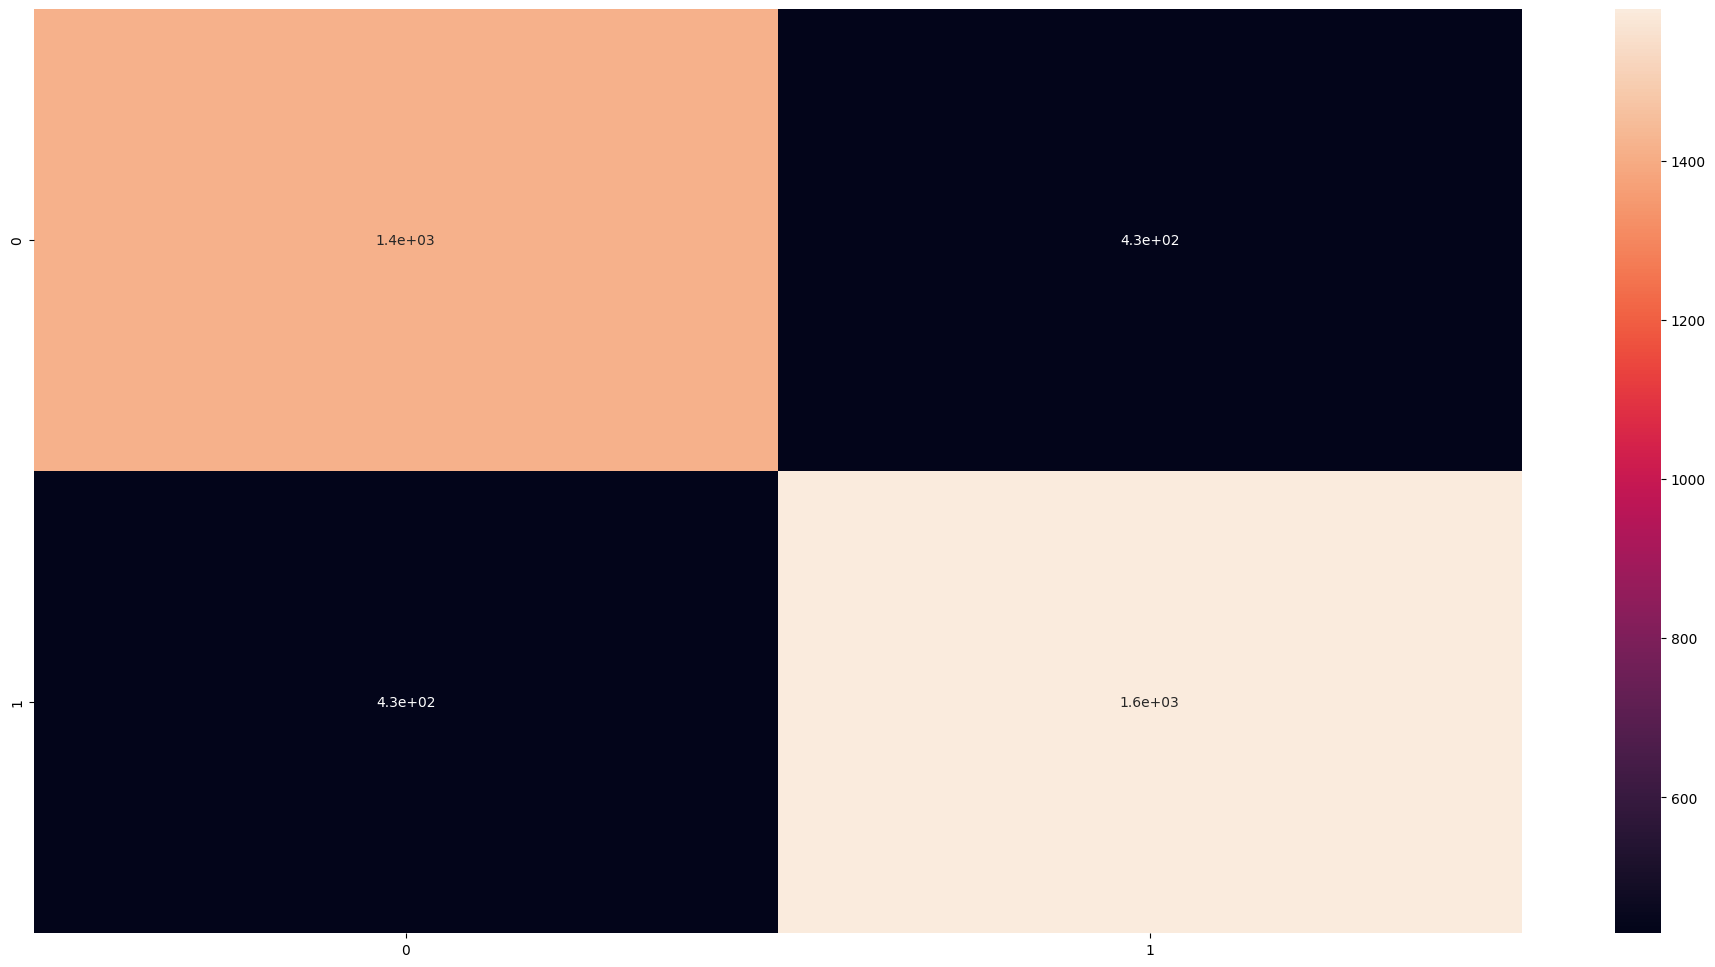

In [22]:
from tqdm import tqdm
import seaborn as sns

cf_matrix = confusion_matrix(y_test, predictions)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24, 12))
sns.heatmap(cf_matrix, annot=True, axes=axes)

## Save Model and Clear RAM

Save model - to Drive

In [23]:
import pickle 

model_name = 'data/Gender_Prediction__SVC.pkl'

# Its important to use binary mode 
with open(model_name, 'wb') as f:      
    # source, destination 
    pickle.dump(best_classifier, f)

## Loading the pre-saved model

In [24]:
import pickle 

# load the model from disk
model_loaded = pickle.load(
    open(model_name, 'rb')
)

## Making Predictions using trained model

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
import os

print("1 = Correctly Classified")
print("0 = Wrongly Classified")
print()
print(f"Status \t Actual Class \t\t Predicted Class")
for _ in range(20):
    index = random.randint(0, len(X_test) - 1)
    image, label = X_test[index], y_test[index]
    actual_class = label_mapping_dict[label]

    predictions = model_loaded.predict([image])
    prediction = predictions[0]
    predicted_class = label_mapping_dict[prediction]
    
    flag = "1" if actual_class == predicted_class else "0"
    label = f"{flag} \t {actual_class} \t {predicted_class}"
    print(label)

1 = Correctly Classified
0 = Wrongly Classified

Status 	 Actual Class 		 Predicted Class
0 	 female 	 male
1 	 male 	 male
1 	 male 	 male
0 	 male 	 female
1 	 female 	 female
1 	 male 	 male
1 	 female 	 female
1 	 female 	 female
0 	 male 	 female
0 	 male 	 female
1 	 male 	 male
1 	 male 	 male
1 	 female 	 female
0 	 male 	 female
0 	 female 	 male
1 	 female 	 female
1 	 female 	 female
1 	 male 	 male
1 	 male 	 male
1 	 female 	 female
